<a href="https://colab.research.google.com/github/Lodia15/Monet_Paintings_Lodia/blob/main/next_Monet_Lodia_1_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
checkpoint_dir = "/content/drive/MyDrive/Monet"
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory:", checkpoint_dir)


Checkpoint directory: /content/drive/MyDrive/Monet


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list


ref                                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                   Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000          14091        315  1.0              
rohiteng/spotify-music-analytics-dataset-20152025                  Spotify Music Analytics Dataset (2015–2025)            5080400  2025-12-04 05:17:45.537000           1552         37  1.0              
neurocipher/heartdisease                                           Heart Disease                                             3491  2025-12-11 15:29:14.327000            856         24  1.0

In [ ]:
! kaggle competitions download -c gan-getting-started

 82% 301M/367M [00:00<00:00, 894MB/s] 
100% 367M/367M [00:00<00:00, 667MB/s]


In [6]:
! unzip gan-getting-started

Archive:  gan-getting-started.zip
replace monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
! pip install wandb weave

In [8]:
! wandb login

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: llodi22 (llodi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
!unzip -qq gan-getting-started.zip -d gan_data

In [10]:
import os
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from PIL import Image
import matplotlib.pyplot as plt
import wandb


# ============================================================
# 1. W&B INIT
# ============================================================
wandb.init(
    project="Monet_Paintings_Lodia",
    config={
        "image_size": 128,
        "batch_size": 1,         # CycleGAN paper also uses batch size = 1
        "lr": 0.0002,
        "beta1": 0.5,
        "beta2": 0.999,
        "lambda_cyc": 10.0,      # weight for cycle-consistency loss
        "lambda_idt": 5.0,       # weight for identity loss (= 0.5 * lambda_cyc)
        "epochs": 25,
        "model": "CycleGAN_LSGAN_ResNet"
    }
)
config = wandb.config

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: llodi22 (llodi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Running on: cuda


In [11]:
class MonetPhotoDataset(Dataset):
    """
    Unpaired dataset:
    - domain A: photos (photo_jpg)
    - domain B: Monet paintings (monet_jpg)

    We don't have aligned pairs, so for each index we pick:
    - one photo from A (cyclic over list)
    - one Monet from B (cyclic over list)
    """

    def __init__(self, root_photo, root_monet, transform=None):
        self.photo_files = sorted(glob(os.path.join(root_photo, "*.jpg")))
        self.monet_files = sorted(glob(os.path.join(root_monet, "*.jpg")))
        self.transform = transform

        self.len_A = len(self.photo_files)
        self.len_B = len(self.monet_files)
        self.length = max(self.len_A, self.len_B)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # cycle through if lengths differ
        photo_path = self.photo_files[idx % self.len_A]
        monet_path = self.monet_files[idx % self.len_B]

        photo = Image.open(photo_path).convert("RGB")
        monet = Image.open(monet_path).convert("RGB")

        if self.transform:
            photo = self.transform(photo)
            monet = self.transform(monet)

        # return (A, B) where:
        # A = real photo, B = real Monet
        return photo, monet


# transforms: resize + flip + tensor + normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])

data_root = "/content/gan_data"
dataset = MonetPhotoDataset(
    root_photo=os.path.join(data_root, "photo_jpg"),
    root_monet=os.path.join(data_root, "monet_jpg"),
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
print("Dataset size:", len(dataset))


Dataset size: 7038


In [12]:
class ResnetBlock(nn.Module):
    """
    A standard residual block used in the CycleGAN paper.

    Structure:
    x → (Conv → IN → ReLU → Conv → IN) + x → output
    """

    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)  # residual connection

In [13]:
class ResnetGenerator(nn.Module):
    """
    ResNet-based generator from the CycleGAN paper.

    c7s1-64, d128, d256, 6×ResNet(256), u128, u64, c7s1-3
    for 128×128 images (6 residual blocks).
    """

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=6):
        super().__init__()
        assert n_blocks >= 0

        model = []

        # Initial 7x7 conv
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True)
        ]

        # Downsampling: 64x64 -> 32x32 -> 16x16 (for 128x128 input)
        in_features = ngf
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3,
                          stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks (keep 256 channels)
        for _ in range(n_blocks):
            model += [ResnetBlock(in_features)]

        # Upsampling: 16x16 -> 32x32 -> 64x64 -> 128x128
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features,
                                   kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Final 7x7 conv to 3 channels + Tanh to [-1, 1]
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [14]:
class PatchDiscriminator(nn.Module):
    """
    70x70 PatchGAN discriminator.

    Instead of outputting a single real/fake score,
    it outputs a grid of scores (one per "patch").
    """

    def __init__(self, input_nc=3, ndf=64):
        super().__init__()

        layers = []

        # No norm on first layer (as in the paper)
        layers += [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        # Next layers with InstanceNorm
        in_features = ndf
        out_features = in_features * 2
        for n in range(1, 4):
            stride = 2 if n < 3 else 1  # last conv has stride 1
            layers += [
                nn.Conv2d(in_features, out_features,
                          kernel_size=4, stride=stride, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features = min(in_features * 2, 512)

        # Final conv -> 1 channel map of patch scores
        layers += [
            nn.Conv2d(in_features, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [15]:
# Generators:
# G_P2M: Photo -> Monet
# G_M2P: Monet -> Photo
G_P2M = ResnetGenerator().to(device)
G_M2P = ResnetGenerator().to(device)

# Discriminators:
# D_P: distinguishes real Photo from fake Photo
# D_M: distinguishes real Monet from fake Monet
D_P = PatchDiscriminator().to(device)
D_M = PatchDiscriminator().to(device)

In [16]:
# Initialize weights (small normal, as in many GAN examples)
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, (nn.InstanceNorm2d, nn.BatchNorm2d)):
        if m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


In [17]:
G_P2M.apply(init_weights)
G_M2P.apply(init_weights)
D_P.apply(init_weights)
D_M.apply(init_weights)

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [18]:
# Loss functions
criterion_GAN = nn.MSELoss()   # LSGAN
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()


In [19]:
# Optimizers: one for both generators, one each for discriminators
optimizer_G = optim.Adam(
    list(G_P2M.parameters()) + list(G_M2P.parameters()),
    lr=config.lr, betas=(config.beta1, config.beta2)
)

optimizer_D_P = optim.Adam(D_P.parameters(), lr=config.lr,
                           betas=(config.beta1, config.beta2))
optimizer_D_M = optim.Adam(D_M.parameters(), lr=config.lr,
                           betas=(config.beta1, config.beta2))


In [24]:
resume_path = "/content/drive/MyDrive/Monet/checkpoint_13.pth"

start_epoch = 1
if resume_path:
    print("Loading checkpoint:", resume_path)
    ckpt = torch.load(resume_path, map_location=device)

    G_P2M.load_state_dict(ckpt["G_P2M"])
    G_M2P.load_state_dict(ckpt["G_M2P"])
    D_P.load_state_dict(ckpt["D_P"])
    D_M.load_state_dict(ckpt["D_M"])

    optimizer_G.load_state_dict(ckpt["opt_G"])
    optimizer_D_P.load_state_dict(ckpt["opt_D_P"])
    optimizer_D_M.load_state_dict(ckpt["opt_D_M"])

    start_epoch = ckpt["epoch"] + 1
    print("Resuming from epoch:", start_epoch)

Loading checkpoint: /content/drive/MyDrive/Monet/checkpoint_13.pth
Resuming from epoch: 14


In [25]:
# helper to denormalize images for visualization
def denorm(t):
    # from [-1, 1] -> [0, 1]
    return (t * 0.5 + 0.5).clamp(0, 1)

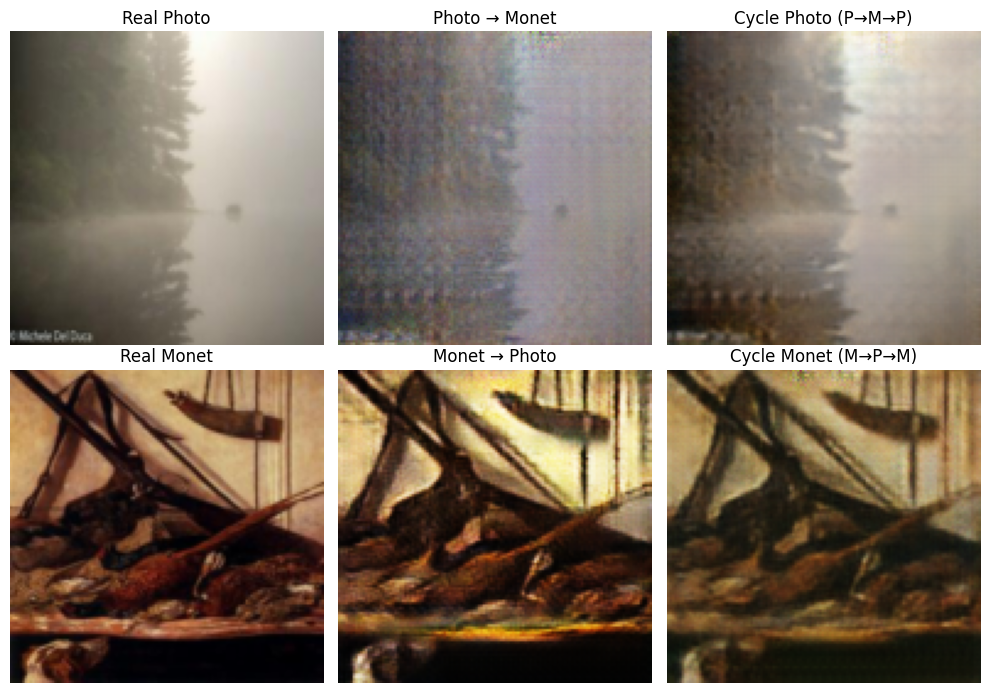

Epoch [14/25] G_total: 4.9763 D_P: 0.1552 D_M: 0.1030
Saved checkpoint: /content/drive/MyDrive/Monet/checkpoint_14.pth


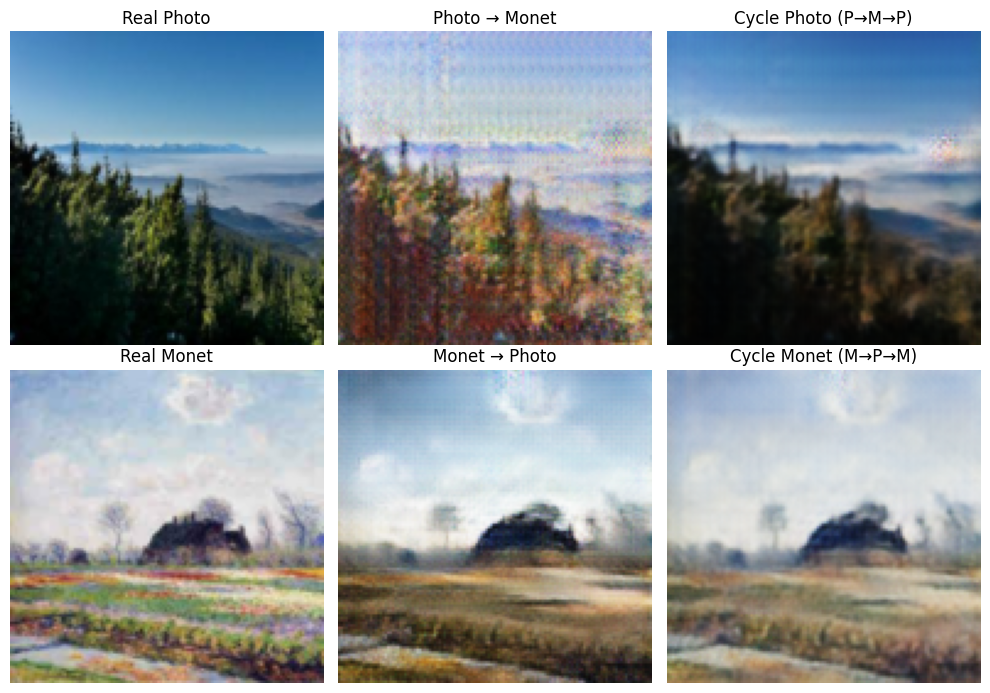

Epoch [15/25] G_total: 4.5740 D_P: 0.2109 D_M: 0.0231
Saved checkpoint: /content/drive/MyDrive/Monet/checkpoint_15.pth


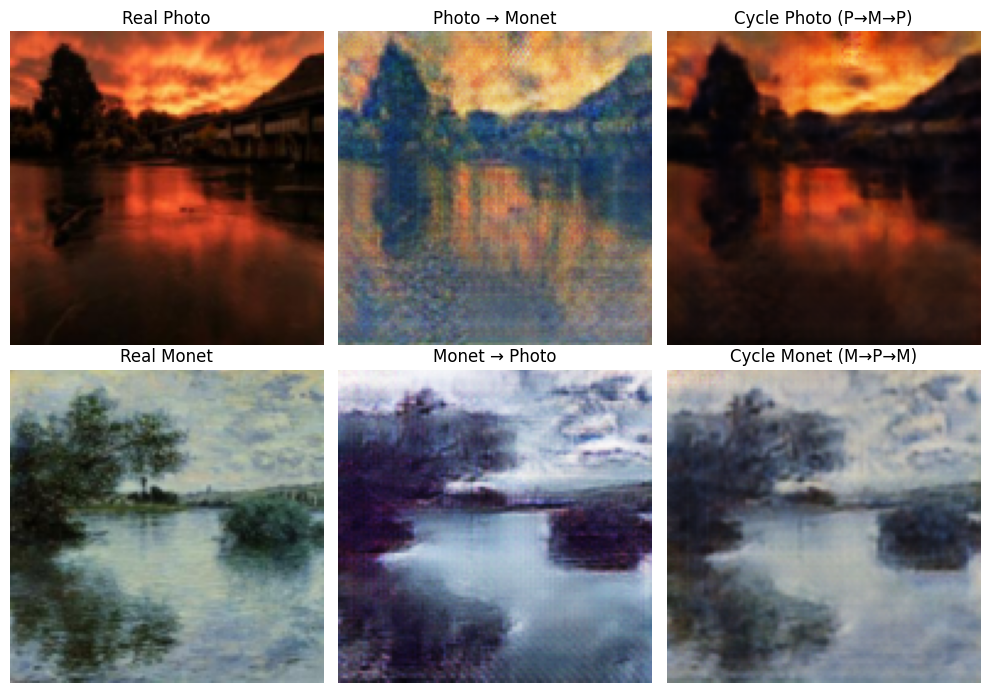

Epoch [16/25] G_total: 5.1863 D_P: 0.2507 D_M: 0.0592
Saved checkpoint: /content/drive/MyDrive/Monet/checkpoint_16.pth


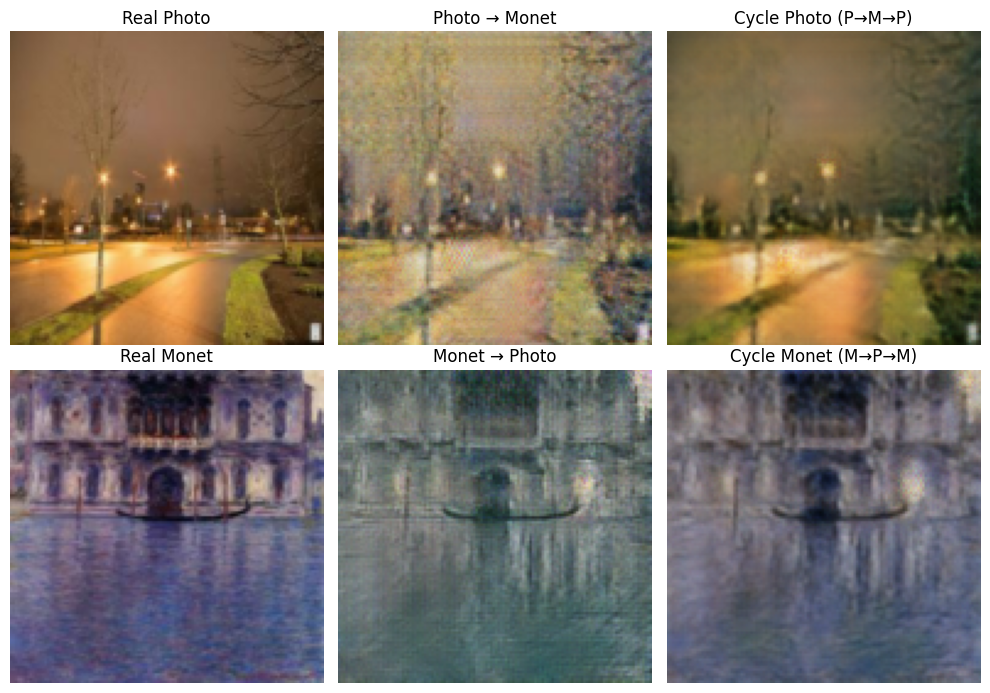

KeyboardInterrupt: 

In [26]:
epochs = config.epochs

for epoch in range(start_epoch, epochs + 1):
    for i, (real_P, real_M) in enumerate(dataloader):
        real_P = real_P.to(device)  # real photos (domain A)
        real_M = real_M.to(device)  # real Monet (domain B)

        # -------------------------------------------
        # 5.1 Train Generators (G_P2M & G_M2P)
        # -------------------------------------------
        optimizer_G.zero_grad()

        # ------- Identity loss -------
        # G_P2M(M) should be close to M (if we feed Monet to Monet-gen)
        # G_M2P(P) should be close to P
        same_M = G_P2M(real_M)
        loss_idt_M = criterion_identity(same_M, real_M) * config.lambda_idt

        same_P = G_M2P(real_P)
        loss_idt_P = criterion_identity(same_P, real_P) * config.lambda_idt

        # ------- GAN loss -------
        # Photo -> Monet
        fake_M = G_P2M(real_P)
        pred_fake_M = D_M(fake_M)
        target_real = torch.ones_like(pred_fake_M, device=device)
        loss_G_P2M = criterion_GAN(pred_fake_M, target_real)

        # Monet -> Photo
        fake_P = G_M2P(real_M)
        pred_fake_P = D_P(fake_P)
        loss_G_M2P = criterion_GAN(pred_fake_P, target_real)

        # ------- Cycle-consistency loss -------
        # P -> M -> P
        rec_P = G_M2P(fake_M)
        loss_cycle_P = criterion_cycle(rec_P, real_P)

        # M -> P -> M
        rec_M = G_P2M(fake_P)
        loss_cycle_M = criterion_cycle(rec_M, real_M)

        loss_cycle_total = (loss_cycle_P + loss_cycle_M) * config.lambda_cyc

        # Total generator loss
        loss_G_total = (
            loss_G_P2M + loss_G_M2P +
            loss_cycle_total +
            loss_idt_P + loss_idt_M
        )

        loss_G_total.backward()
        optimizer_G.step()

        # -------------------------------------------
        # 5.2 Train Discriminator D_M (Monet domain)
        # -------------------------------------------
        optimizer_D_M.zero_grad()

        # real Monet
        pred_real_M = D_M(real_M)
        target_real = torch.ones_like(pred_real_M, device=device)
        loss_D_M_real = criterion_GAN(pred_real_M, target_real)

        # fake Monet (detach so G is not updated here)
        pred_fake_M = D_M(fake_M.detach())
        target_fake = torch.zeros_like(pred_fake_M, device=device)
        loss_D_M_fake = criterion_GAN(pred_fake_M, target_fake)

        loss_D_M_total = 0.5 * (loss_D_M_real + loss_D_M_fake)
        loss_D_M_total.backward()
        optimizer_D_M.step()

        # -------------------------------------------
        # 5.3 Train Discriminator D_P (Photo domain)
        # -------------------------------------------
        optimizer_D_P.zero_grad()

        pred_real_P = D_P(real_P)
        target_real = torch.ones_like(pred_real_P, device=device)
        loss_D_P_real = criterion_GAN(pred_real_P, target_real)

        pred_fake_P = D_P(fake_P.detach())
        target_fake = torch.zeros_like(pred_fake_P, device=device)
        loss_D_P_fake = criterion_GAN(pred_fake_P, target_fake)

        loss_D_P_total = 0.5 * (loss_D_P_real + loss_D_P_fake)
        loss_D_P_total.backward()
        optimizer_D_P.step()

        # -------------------------------------------
        # 5.4 Logging
        # -------------------------------------------
        wandb.log({
            "G_total": loss_G_total.item(),
            "G_P2M_adv": loss_G_P2M.item(),
            "G_M2P_adv": loss_G_M2P.item(),
            "cycle_loss": loss_cycle_total.item(),
            "idt_P": loss_idt_P.item(),
            "idt_M": loss_idt_M.item(),
            "D_M": loss_D_M_total.item(),
            "D_P": loss_D_P_total.item()
        })

        # For first batch of each epoch, also create visualizations
        if i == 0:
            with torch.no_grad():
                # use first item in batch for clarity
                p = real_P[0:1]
                m = real_M[0:1]

                fake_m = G_P2M(p)
                cycle_p = G_M2P(fake_m)

                fake_p = G_M2P(m)
                cycle_m = G_P2M(fake_p)

                # denormalize
                p_vis = denorm(p[0]).cpu()
                m_vis = denorm(m[0]).cpu()
                fake_m_vis = denorm(fake_m[0]).cpu()
                fake_p_vis = denorm(fake_p[0]).cpu()
                cycle_p_vis = denorm(cycle_p[0]).cpu()
                cycle_m_vis = denorm(cycle_m[0]).cpu()

                # ---- Show in Colab with matplotlib ----
                fig, axes = plt.subplots(2, 3, figsize=(10, 7))

                # Row 1: Photo domain
                axes[0, 0].imshow(p_vis.permute(1, 2, 0).numpy())
                axes[0, 0].set_title("Real Photo")
                axes[0, 0].axis("off")

                axes[0, 1].imshow(fake_m_vis.permute(1, 2, 0).numpy())
                axes[0, 1].set_title("Photo → Monet")
                axes[0, 1].axis("off")

                axes[0, 2].imshow(cycle_p_vis.permute(1, 2, 0).numpy())
                axes[0, 2].set_title("Cycle Photo (P→M→P)")
                axes[0, 2].axis("off")

                # Row 2: Monet domain
                axes[1, 0].imshow(m_vis.permute(1, 2, 0).numpy())
                axes[1, 0].set_title("Real Monet")
                axes[1, 0].axis("off")

                axes[1, 1].imshow(fake_p_vis.permute(1, 2, 0).numpy())
                axes[1, 1].set_title("Monet → Photo")
                axes[1, 1].axis("off")

                axes[1, 2].imshow(cycle_m_vis.permute(1, 2, 0).numpy())
                axes[1, 2].set_title("Cycle Monet (M→P→M)")
                axes[1, 2].axis("off")

                plt.tight_layout()
                plt.show()

                # ---- Also send a grid to wandb ----
                # shape (6, 3, H, W) -> grid 2x3
                vis_tensor = torch.stack([
                    p_vis, fake_m_vis, cycle_p_vis,
                    m_vis, fake_p_vis, cycle_m_vis
                ])
                vis_grid = utils.make_grid(vis_tensor, nrow=3)
                wandb.log({"cycle_examples": wandb.Image(vis_grid)})

    print(
        f"Epoch [{epoch}/{epochs}] "
        f"G_total: {loss_G_total.item():.4f} "
        f"D_P: {loss_D_P_total.item():.4f} "
        f"D_M: {loss_D_M_total.item():.4f}"
    )

    # SAVE CHECKPOINT
    checkpoint_path = f"{checkpoint_dir}/checkpoint_{epoch}.pth"
    torch.save({
        "epoch": epoch,
        "G_P2M": G_P2M.state_dict(),
        "G_M2P": G_M2P.state_dict(),
        "D_P": D_P.state_dict(),
        "D_M": D_M.state_dict(),
        "opt_G": optimizer_G.state_dict(),
        "opt_D_P": optimizer_D_P.state_dict(),
        "opt_D_M": optimizer_D_M.state_dict(),
    }, checkpoint_path)

    print(f"Saved checkpoint: {checkpoint_path}")



wandb.finish()